In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
# odeint approach
from neural_net import create_train_state, train, neural_ode
# collocation approach
from neural_net import create_train_state_collocation, train_collocation, predict_derivatives

In [2]:
n_points = 200
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

## Odeint Neural ODE

In [3]:
y0 = jnp.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
y_pred_results = {}

for i, noise_level in enumerate([0.0, 0.1, 0.2, 0.5]):

    # generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    # create the new state
    rng = random.PRNGKey(0)
    state = create_train_state(rng, layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_state = train(state, t, y_noisy, y0)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    y_pred = neural_ode(trained_state.params, y0, t, trained_state)
    y_pred_results[str(i)] = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}

/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/linear_util.py:192: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/mariiashapo/anaconda3/envs/collocation_env

Epoch 0, Loss: 1.8474524021148682
Epoch 100, Loss: 0.2896018326282501
Epoch 200, Loss: 0.17026421427726746
Epoch 300, Loss: 0.09415130317211151
Epoch 400, Loss: 0.0165241789072752
Epoch 500, Loss: 0.03884956240653992
Epoch 600, Loss: 0.05964546650648117
Epoch 700, Loss: 0.021499555557966232
Epoch 800, Loss: 0.035080816596746445
Epoch 900, Loss: 0.015544428490102291
Time elapsed: 85.55836296081543
Epoch 0, Loss: 1.8463414907455444
Epoch 100, Loss: 0.22867386043071747
Epoch 200, Loss: 0.09451735019683838
Epoch 300, Loss: 0.0810016542673111
Epoch 400, Loss: 0.09427940845489502
Epoch 500, Loss: 0.08179795742034912
Epoch 600, Loss: 0.08012134581804276
Epoch 700, Loss: 0.09633663296699524
Epoch 800, Loss: 0.08723432570695877
Epoch 900, Loss: 0.0914195254445076
Time elapsed: 81.97550010681152
Epoch 0, Loss: 1.8497134447097778
Epoch 100, Loss: 0.1775684356689453
Epoch 200, Loss: 0.17691659927368164
Epoch 300, Loss: 0.1598712056875229
Epoch 400, Loss: 0.15985530614852905
Epoch 500, Loss: 0.1649

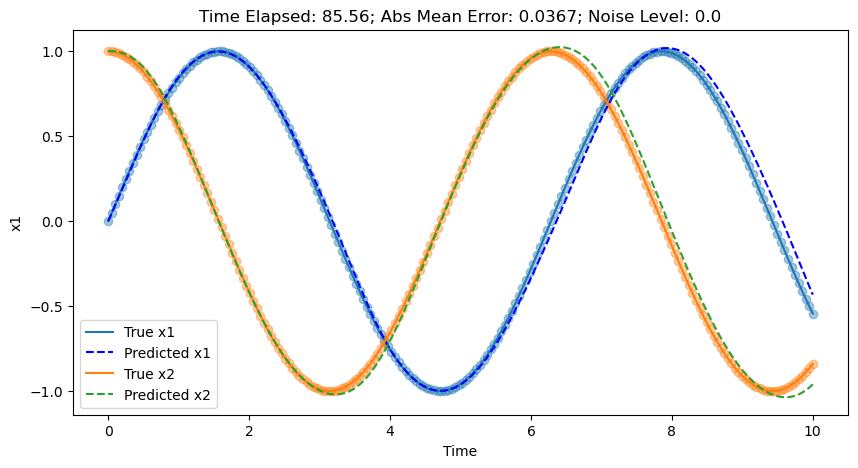

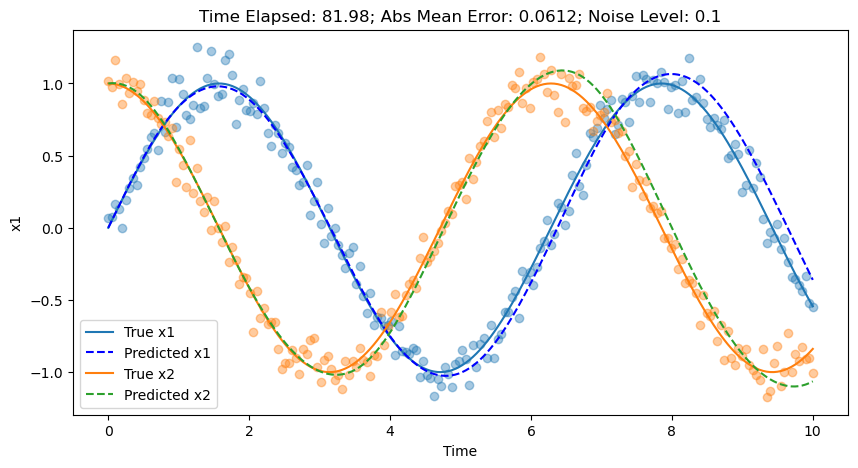

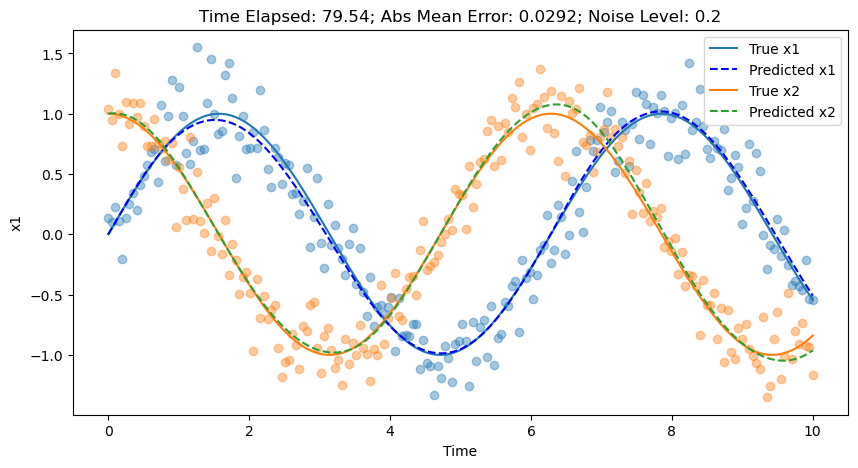

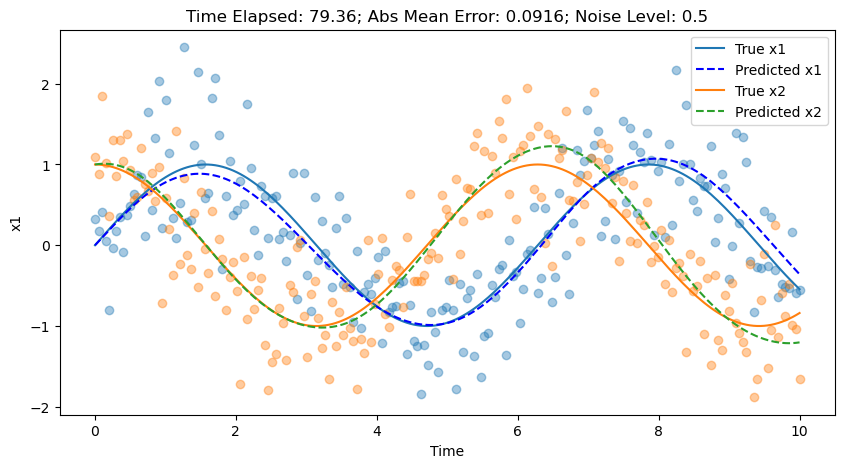

In [4]:
for i in range(len(y_pred_results)):
    result = y_pred_results[str(i)]
    y_pred = result["predictions"]
    y_noisy = result["y_noisy"]
    plt.figure(figsize=(10, 5))
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.4)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    ame = jnp.mean(jnp.abs(y_pred - y))
    plt.title(f'Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {ame:.4f}; Noise Level: {result["noise_level"]}')
    plt.show()

## Collocation Based Neural ODE

In [5]:
def integrate_derivative(t, dy_dt, y0):
    y = jnp.zeros_like(dy_dt)
    y = y.at[0].set(y0)
    for i in range(1, len(dy_dt)):
        dt = t[i] - t[i - 1]
        y = y.at[i].set(y[i - 1] + dy_dt[i - 1] * dt)
    return y

In [6]:
y0 = jnp.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
y_pred_results_collocation = {}
non_param_collocation_results = {}

for i, noise_level in enumerate([0.0, 0.1, 0.2, 0.5]):

    # generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)
    non_param_collocation_results[str(i)] = {"y_true":y, "y_noisy": y_noisy, "t":t, "noise_level": noise_level, "estimated_derivative":estimated_derivative, "estimated_solution":estimated_solution}
    
    # create the new state
    rng = random.PRNGKey(0)
    input_shape = (2, )
    state = create_train_state_collocation(rng, layer_widths, input_shape, learning_rate)
    
    start_timer = time.time()
    # train_collocation(state_coll, t2, estimated_derivative.T, num_epochs= 10000)
    t_t = jnp.array([t,t])
    trained_state = train_collocation(state, t_t.T, estimated_derivative.T, num_epochs=10000)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    dy_dt_pred = predict_derivatives(trained_state, t_t.T)
    y_pred = integrate_derivative(t_t.T, dy_dt_pred, y0)
    
    y_pred_results_collocation[str(i)] = {"dy_dt_predictions": dy_dt_pred, "y_pred": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}
    

Epoch 0, Loss: 0.6563237905502319
Epoch 1000, Loss: 0.06968510150909424
Epoch 2000, Loss: 0.028240809217095375
Epoch 3000, Loss: 0.010666217654943466
Epoch 4000, Loss: 0.01619458571076393
Epoch 5000, Loss: 0.012794731184840202
Epoch 6000, Loss: 0.016459105536341667
Epoch 7000, Loss: 0.008233793079853058
Epoch 8000, Loss: 0.014916965737938881
Epoch 9000, Loss: 0.009576449170708656
Time elapsed: 3.237049102783203
Epoch 0, Loss: 0.651178240776062
Epoch 1000, Loss: 0.07592812180519104
Epoch 2000, Loss: 0.06270572543144226
Epoch 3000, Loss: 0.057093095034360886
Epoch 4000, Loss: 0.05049210041761398
Epoch 5000, Loss: 0.04134631156921387
Epoch 6000, Loss: 0.03608512133359909
Epoch 7000, Loss: 0.03317508473992348
Epoch 8000, Loss: 0.031008196994662285
Epoch 9000, Loss: 0.026804795488715172
Time elapsed: 3.06653094291687
Epoch 0, Loss: 0.6724408864974976
Epoch 1000, Loss: 0.14224956929683685
Epoch 2000, Loss: 0.117245614528656
Epoch 3000, Loss: 0.09520388394594193
Epoch 4000, Loss: 0.0784471854

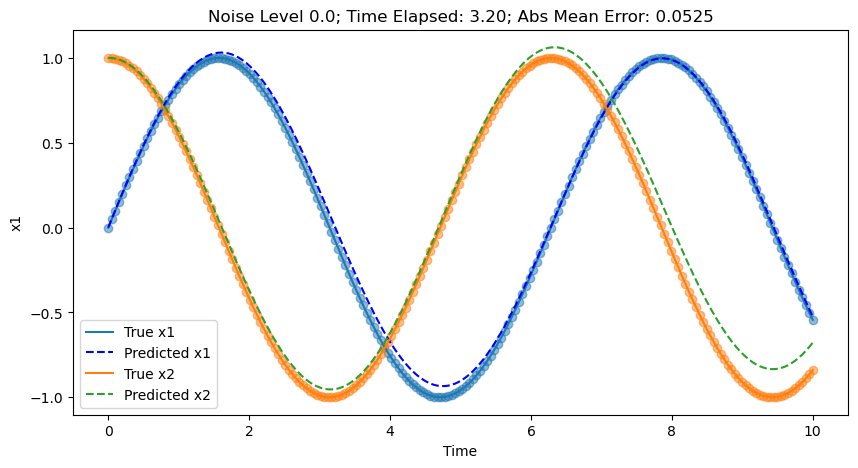

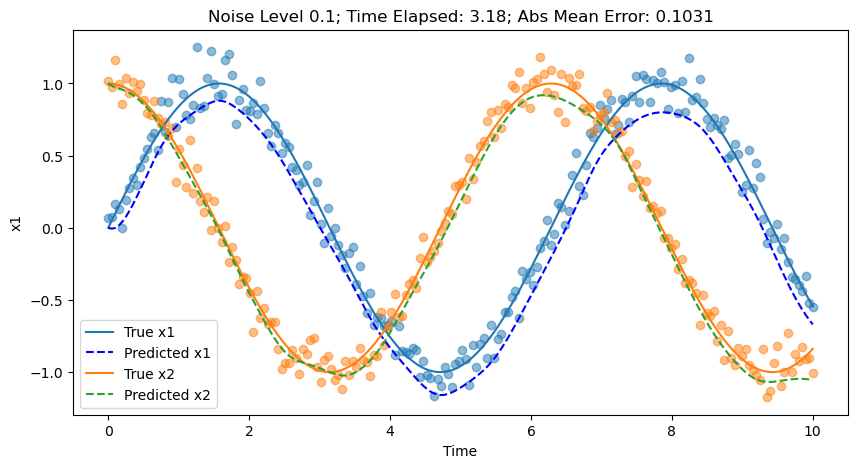

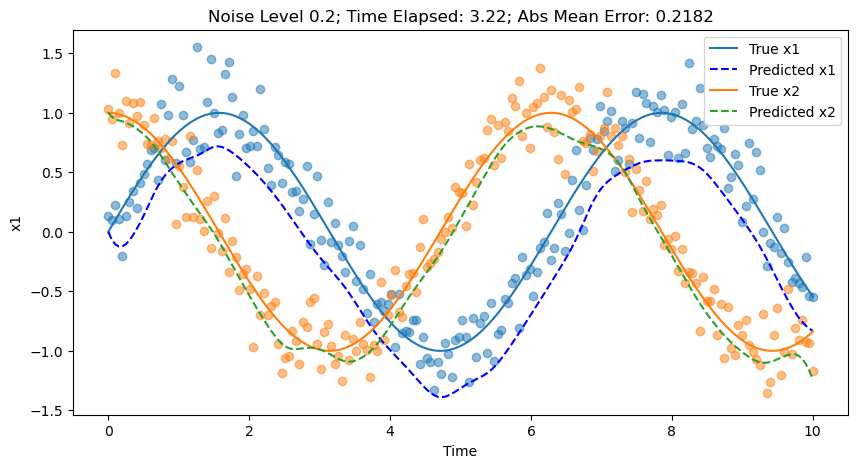

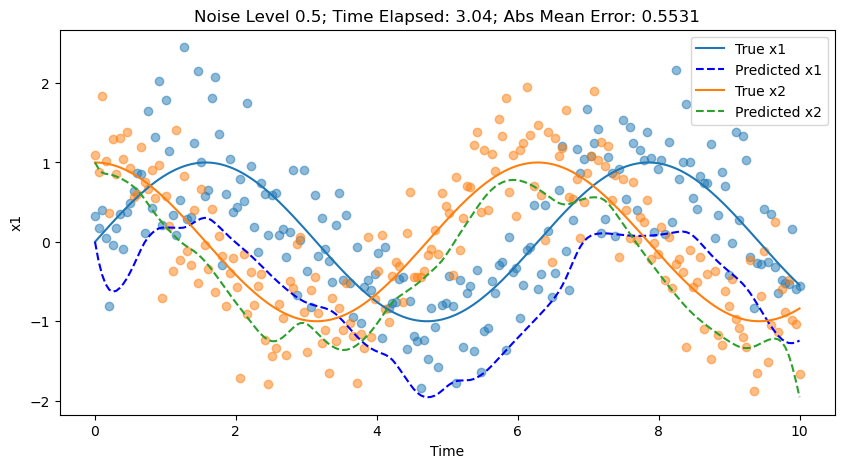

In [19]:
for i in range(len(y_pred_results_collocation)):
    result = y_pred_results_collocation[str(i)]
    
    y_pred = result["y_pred"]
    y_noisy = result["y_noisy"]
    plt.figure(figsize=(10, 5))
    
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.5)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    ame = jnp.mean(jnp.abs(y_pred - y))
    plt.title(f'Noise Level {result["noise_level"]}; Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {ame:.4f}')
    plt.show()

## Predictions - standard odeint

In [3]:
n_points = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

y0 = jnp.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
# generate data for the according noise level
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# create the new state
rng = random.PRNGKey(0)
state = create_train_state(rng, layer_widths, learning_rate)

start_timer = time.time()
trained_state = train(state, t, y_noisy, y0)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

# generate predictions for the train data range
y_pred = neural_ode(trained_state.params, y0, t, trained_state)
y_pred_med_noise = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}

Epoch 0, Loss: 1.8497134447097778
Epoch 100, Loss: 0.1775684356689453
Epoch 200, Loss: 0.17691659927368164
Epoch 300, Loss: 0.1598712056875229
Epoch 400, Loss: 0.15985530614852905
Epoch 500, Loss: 0.16492946445941925
Epoch 600, Loss: 0.17036636173725128
Epoch 700, Loss: 0.16043686866760254
Epoch 800, Loss: 0.16494213044643402
Epoch 900, Loss: 0.1728213131427765
Time elapsed: 84.30877780914307


In [20]:
# change the end_time to 20
start_time, end_time = 0, 20
n_points = 100 + (end_time - 10)*10
    
# generate data for the according noise level
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# generate predictions beyong the train data range
y_pred = neural_ode(trained_state.params, y0, t, trained_state)
y_pred_med_noise = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}

Abs Mean Error Train: 0.0290; Abs Mean Error Test: 0.2289


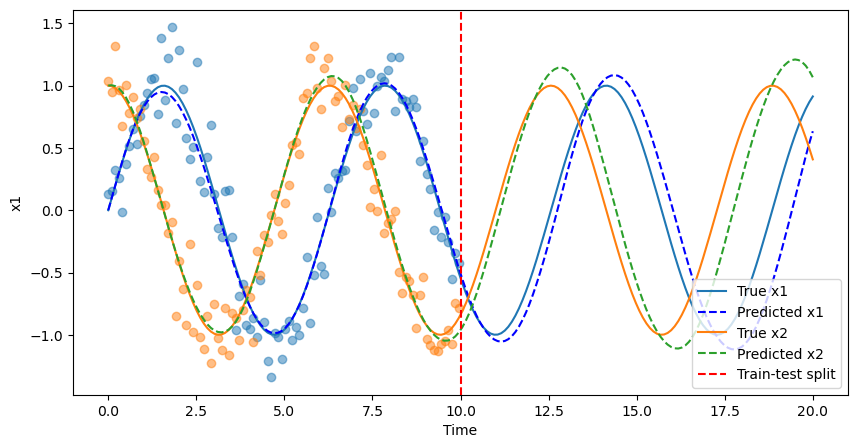

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t[:100], y_noisy[:100, 0], alpha = 0.5)
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t[:100], y_noisy[:100, 1], alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('x1')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc='lower right')
ame_train = jnp.mean(jnp.abs(y_pred[:100] - y[:100]))
ame_test = jnp.mean(jnp.abs(y_pred[100:] - y[100:]))
print(f'Abs Mean Error Train: {ame_train:.4f}; Abs Mean Error Test: {ame_test:.4f}')
plt.show()

In [31]:
start_time, end_time = 0, 10

# generate data for the according noise level
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

#--------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

rng = random.PRNGKey(0)
input_shape = (2, )
state = create_train_state_collocation(rng, layer_widths, input_shape, learning_rate)

start_timer = time.time()
t_t = jnp.array([t,t])
trained_state = train_collocation(state, t_t.T, estimated_derivative.T, num_epochs=10000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

# generate predictions
dy_dt_pred = predict_derivatives(trained_state, t_t.T)
y_pred = integrate_derivative(t_t.T, dy_dt_pred, y0)

y_pred_med_noise_collocation = {"dy_dt_predictions": dy_dt_pred, "y_pred": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}

Epoch 0, Loss: 0.6724408864974976
Epoch 1000, Loss: 0.14224956929683685
Epoch 2000, Loss: 0.117245614528656
Epoch 3000, Loss: 0.09520388394594193
Epoch 4000, Loss: 0.07844718545675278
Epoch 5000, Loss: 0.07068025320768356
Epoch 6000, Loss: 0.06306780874729156
Epoch 7000, Loss: 0.05470258742570877
Epoch 8000, Loss: 0.04719560220837593
Epoch 9000, Loss: 0.04235590994358063
Time elapsed: 3.680103063583374


In [28]:
start_time, end_time = 0, 20
# generate data for the according noise level
t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
t_t = jnp.array([t,t])

In [29]:
dy_dt_pred = predict_derivatives(trained_state, t_t.T)
y_pred = integrate_derivative(t_t.T, dy_dt_pred, y0)

Abs Mean Error Train: 0.2415; Abs Mean Error Test: 7.6418


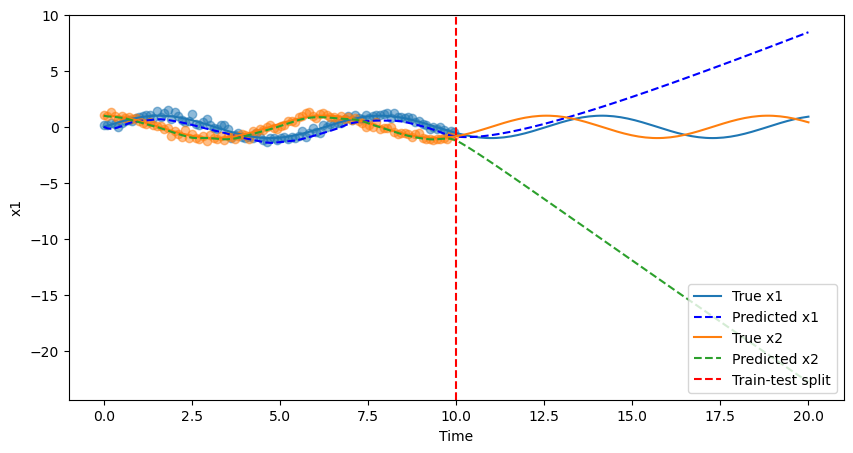

In [30]:
plt.figure(figsize=(10, 5))

plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t[:100], y_noisy[:100, 0], alpha = 0.5)
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t[:100], y_noisy[:100, 1], alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('x1')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc='lower right')
ame_train = jnp.mean(jnp.abs(y_pred[:100] - y[:100]))
ame_test = jnp.mean(jnp.abs(y_pred[100:] - y[100:]))
print(f'Abs Mean Error Train: {ame_train:.4f}; Abs Mean Error Test: {ame_test:.4f}')
plt.show()